In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from utils import *

In [50]:
# Set display format for floats to regular decimal notation
pd.set_option('display.float_format', '{:.20f}'.format)

In [51]:
tickers = [
    "AAPL", "MSFT", "GOOG", "AMZN", "NVDA", "ADBE", "ORCL", "CRM", "INTC", "CSCO",  # Technology
    "JNJ", "PFE", "MRK", "UNH", "BMY", "LLY", "ABBV", "GILD", "MDT", "ELV",         # Healthcare
    "PG", "KO", "PEP", "WMT", "CL", "KMB", "MO", "MDLZ", "GIS", "COST",             # Consumer Staples
    "TSLA", "NKE", "MCD", "SBUX", "TGT", "HD", "LOW", "TJX", "ROST", "AMT",         # Consumer Discretionary
    "JPM", "BAC", "GS", "WFC", "C", "AXP", "SCHW", "MS", "BLK", "USB",              # Financials
    "BA", "CAT", "MMM", "HON", "UNP", "LMT", "GE", "RTX", "UPS", "DE",              # Industrials
    "NEE", "DUK", "SO", "AEP", "EXC", "D", "XEL", "ED", "SRE", "PPL",               # Utilities
    "VZ", "T", "CMCSA", "DIS", "NFLX", "GOOGL", "META", "CHTR", "TMUS", "SPOT",     # Communication Services
    "XOM", "CVX", "COP", "SLB", "PSX", "VLO", "MPC", "HAL", "BKR", "OXY",           # Energy
    "IEF", "TLT", "GOVT", "BND", "LQD", "HYG", "TIP", "AGG", "VCIT", "VCSH",        # Bonds
    "VNQ", "IYR", "SCHH", "RWR", "XLRE", "PLD", "O", "SPG", "AVB", "EQR",           # REITs
    "GLD", "IAU", "SLV", "PDBC", "DBC", "USO", "UNG", "BNO", "GSG", "CORN"          # Commodities
]

# Download historical data for all tickers
data = yf.download(tickers, start="2005-01-01", end="2024-10-01")['Adj Close']

# Display the first few rows
# print(data.head())

[*********************100%%**********************]  120 of 120 completed


## Calculating Metrics

In [52]:
target_risk = 0.08

In [53]:
daily_returns = daily_returns_calc(data)
expected_daily_metrics = expected_daily_metric_calc(daily_returns)
expected_daily_returns = expected_daily_metrics['daily_returns']
daily_covariance_matrix = expected_daily_metrics['daily_covariance']
annual_metrics = annual_metrics_calc(expected_daily_returns, daily_covariance_matrix)
annual_returns = annual_metrics['annual_returns']
annual_covariance = annual_metrics['cov_matrix']

/Users/meganng/Desktop/DSA4212/Assignment/final/utils.py:14: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.



## Running Optimisation on Unperturbed Data

In [54]:
# Running optimisation with target risk as 0.05
res = optimise_weights(annual_returns, annual_covariance, target_risk)
original_weights = res[0]

## Stability with Random Perturbations 

In [55]:
# Set random seed
np.random.seed(6701)
# Generate 20 values between 0.001 and 0.02
perturbations = np.linspace(0.0001, 0.02, 50)

In [56]:
# Lists to store final results
tot_mean = []
tot_max = []
tot_std = []
optimal_returns = []
optimal_risks = []

for perturbation in perturbations:
    # List to store differences in weights for each run
    weight_differences = []
    portfolio_returns = []
    portfolio_risks = []
    
    feasible_solution = True  # Flag to check if any solution is feasible

    for i in range(5):
        # Add random perturbation to the returns data
        perturbed_returns = daily_returns + np.random.normal(0, perturbation, daily_returns.shape)

        # Calculate covariance matrix and expected returns from perturbed data
        perturbed_cov_matrix = perturbed_returns.cov() * 252  # Annualized covariance matrix
        perturbed_expected_returns = perturbed_returns.mean() * 252  # Annualized expected returns

        # Define portfolio weights
        n_assets = len(perturbed_expected_returns)
        weights = cp.Variable(n_assets)

        # Define portfolio return and risk (variance)
        portfolio_return = perturbed_expected_returns.values @ weights
        portfolio_risk = cp.quad_form(weights, cp.psd_wrap(perturbed_cov_matrix))

        # Optimize to maximize return for a given risk
        target_risk = 0.08
        problem = cp.Problem(cp.Maximize(portfolio_return), [
            cp.sum(weights) == 1,
            weights >= 0,
            portfolio_risk <= target_risk**2
        ])
        
        problem.solve()

        # Check if the solution is feasible
        if problem.status != cp.OPTIMAL:
            feasible_solution = False
            break  # Stop further iterations if no feasible solution is found

        # Collect weights and portfolio metrics if feasible
        perturbed_weights = np.round(weights.value, 4)
        weight_diff = np.abs(original_weights - perturbed_weights)
        weight_differences.append(weight_diff)

        portfolio_returns.append(portfolio_return.value)
        portfolio_risks.append(portfolio_risk.value)

    if feasible_solution:
        # Calculate mean, max, std change in weights if solution was feasible
        diff_df = pd.DataFrame(weight_differences)
        tot_mean.append(diff_df.mean().mean())
        tot_max.append(diff_df.max().mean())
        tot_std.append(diff_df.std().mean())
        optimal_returns.append(sum(portfolio_returns) / len(portfolio_returns))
        optimal_risks.append(sum(portfolio_risks) / len(portfolio_risks))
    else:
        # Append None for all columns if no feasible solution was found
        tot_mean.append(None)
        tot_max.append(None)
        tot_std.append(None)
        optimal_returns.append(None)
        optimal_risks.append(None)

# Creating a new DataFrame
final_df = pd.DataFrame({
    'Perturbation Level': perturbations,
    'Average Change': tot_mean,
    'Average Maximum Change': tot_max,
    'Average SD': tot_std,
    'Average Returns': optimal_returns,
    'Average Risk': optimal_risks
})

# Display the final dataframe
print(final_df)


       Perturbation Level         Average Change  Average Maximum Change  \
0  0.00010000000000000000 0.00027539768276297461  0.00082429418154864498   
1  0.00050612244897959191 0.00207343412216459948  0.00601094036179607508   
2  0.00091224489795918378 0.00352430045815131177  0.00610132805249742009   
3  0.00131836734693877564 0.00418517032229672337  0.00797482664456651384   
4  0.00172448979591836751 0.00536283329687551203  0.01282626859554369253   
5  0.00213061224489795916 0.00523435419898341404  0.01190298092140393803   
6  0.00253673469387755103 0.00542801528358220677  0.01247105207368559912   
7  0.00294285714285714289 0.00437045526569491451  0.01149468137794890446   
8  0.00334897959183673476 0.00506192248423490126  0.01260502286955336899   
9  0.00375510204081632663 0.00636419596312908561  0.01624401467541804894   
10 0.00416122448979591893 0.00628585049753843141  0.01434479492268962188   
11 0.00456734693877551123 0.00775973820142942475  0.01609777683060545361   
12 0.0049734

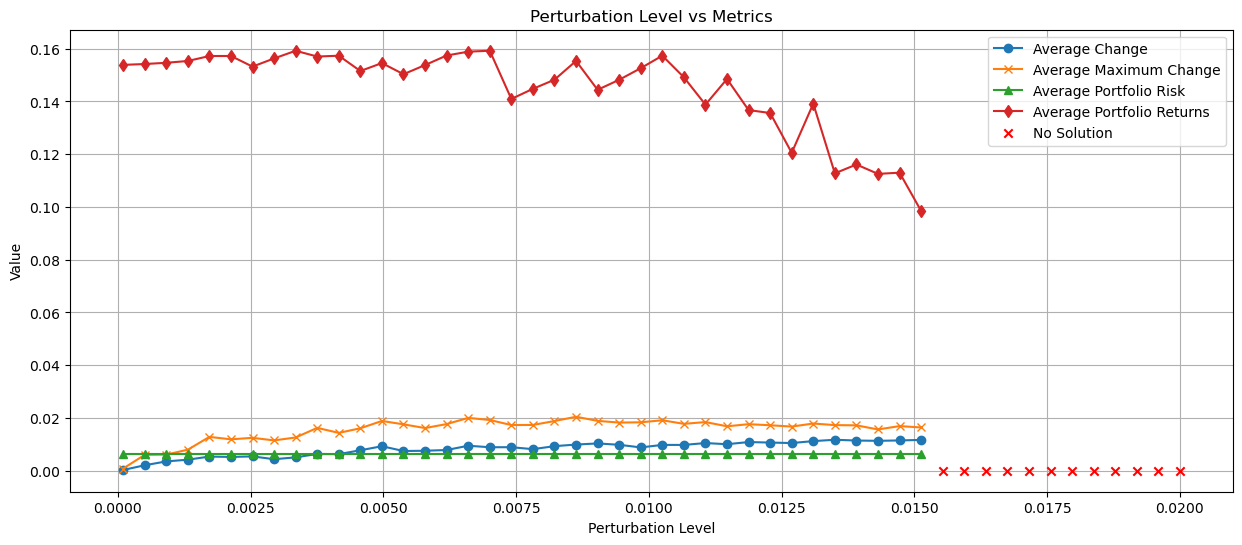

In [57]:
# Plotting the results
plt.figure(figsize=(15, 6))

# Plot each line, skipping NaNs
for column, label, marker in zip(
        ['Average Change', 'Average Maximum Change', 'Average Risk', 'Average Returns'],
        ['Average Change', 'Average Maximum Change', 'Average Portfolio Risk', 'Average Portfolio Returns'],
        ['o', 'x', '^', 'd']):
    
    # Plot the main line (excluding NaNs)
    plt.plot(final_df['Perturbation Level'], final_df[column], label=label, marker=marker, linestyle='-')

# Plot the "No Solution" markers for all columns at once
nan_indices = final_df['Perturbation Level'][final_df.isna().any(axis=1)]
plt.scatter(nan_indices, [0] * len(nan_indices), color='red', marker='x', label='No Solution', zorder=3)

# Set the labels and title
plt.xlabel('Perturbation Level')
plt.ylabel('Value')
plt.title('Perturbation Level vs Metrics')

# Display the legend
plt.legend()
plt.grid(True)
plt.show()


### Stabilising the Portfolio

#### Only Exponential Shrinkage

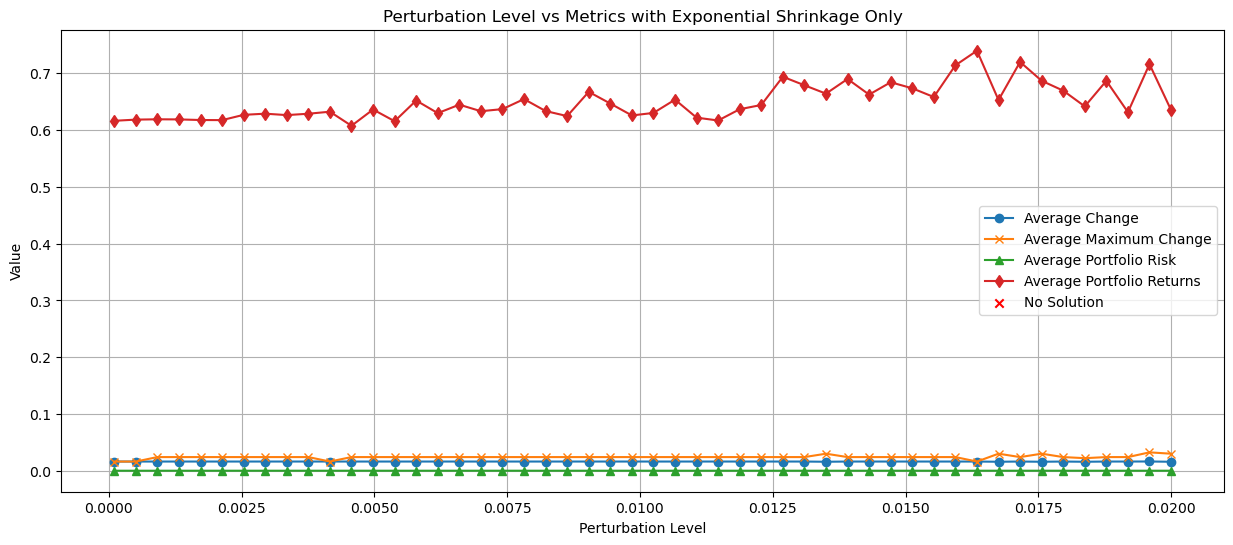

In [58]:
# Lists to store final results
tot_mean = []
tot_max = []
tot_std = []
optimal_returns = []
optimal_risks = []

# Exponential weighting factor (closer to 1 emphasizes recent data more strongly)
alpha = 0.8  # Adjust this as needed to control the weighting

for perturbation in perturbations:
    weight_differences = []
    portfolio_returns = []
    portfolio_risks = []
    feasible_solution = True

    for i in range(5):
        # Add random perturbation to the returns data
        perturbed_returns = daily_returns + np.random.normal(0, perturbation, daily_returns.shape)

        # Calculate exponentially weighted covariance matrix
        weights = alpha ** np.arange(len(perturbed_returns) - 1, -1, -1)
        weights /= weights.sum()  # Normalize weights to sum to 1
        weighted_returns = perturbed_returns.multiply(weights, axis=0)
        perturbed_cov_matrix = weighted_returns.cov() * 252  # Annualize covariance

        # Calculate expected returns (annualized)
        perturbed_expected_returns = perturbed_returns.mean() * 252

        # Define the optimization problem with cvxpy
        n_assets = len(perturbed_expected_returns)
        weights = cp.Variable(n_assets)

        # Portfolio return and risk (variance)
        portfolio_return = perturbed_expected_returns.values @ weights
        portfolio_risk = cp.quad_form(weights, cp.psd_wrap(perturbed_cov_matrix))

        # Optimization problem: Maximize return with risk constraint
        target_risk = 0.08  # Set target risk level
        problem = cp.Problem(cp.Maximize(portfolio_return), [
            cp.sum(weights) == 1,  # Sum of weights must be 1
            weights >= 0,  # No short-selling
            portfolio_risk <= target_risk**2  # Risk constraint
        ])
        
        problem.solve()

        # Check if solution is feasible
        if problem.status != cp.OPTIMAL:
            feasible_solution = False
            break

        # Collect results if feasible
        perturbed_weights = np.round(weights.value, 4)
        weight_diff = np.abs(original_weights - perturbed_weights)
        weight_differences.append(weight_diff)
        portfolio_returns.append(portfolio_return.value)
        portfolio_risks.append(portfolio_risk.value)

    # Append results if feasible
    if feasible_solution:
        diff_df = pd.DataFrame(weight_differences)
        tot_mean.append(diff_df.mean().mean())
        tot_max.append(diff_df.max().mean())
        tot_std.append(diff_df.std().mean())
        optimal_returns.append(np.mean(portfolio_returns))
        optimal_risks.append(np.mean(portfolio_risks))
    else:
        tot_mean.append(None)
        tot_max.append(None)
        tot_std.append(None)
        optimal_returns.append(None)
        optimal_risks.append(None)

# Creating a new DataFrame for analysis
final_df = pd.DataFrame({
    'Perturbation Level': perturbations,
    'Average Change': tot_mean,
    'Average Maximum Change': tot_max,
    'Average SD': tot_std,
    'Average Returns': optimal_returns,
    'Average Risk': optimal_risks
})

# Plotting the results
plt.figure(figsize=(15, 6))
for column, label, marker in zip(
        ['Average Change', 'Average Maximum Change', 'Average Risk', 'Average Returns'],
        ['Average Change', 'Average Maximum Change', 'Average Portfolio Risk', 'Average Portfolio Returns'],
        ['o', 'x', '^', 'd']):
    
    plt.plot(final_df['Perturbation Level'], final_df[column], label=label, marker=marker, linestyle='-')

nan_indices = final_df['Perturbation Level'][final_df.isna().any(axis=1)]
plt.scatter(nan_indices, [0] * len(nan_indices), color='red', marker='x', label='No Solution', zorder=3)

plt.xlabel('Perturbation Level')
plt.ylabel('Value')
plt.title('Perturbation Level vs Metrics with Exponential Shrinkage Only')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
final_df

,Perturbation Level,Average Change,Average Maximum Change,Average SD,Average Returns,Average Risk
0,0.00010000000000000000,0.01616634433729987816,0.01616634433729987816,0.00000000000000000116,0.61645054514683295110,0.00000669977517334806
1,0.00050612244897959191,0.01616634433729987816,0.01616634433729987816,0.00000000000000000116,0.61852599738516977901,0.00000672518589974950
2,0.00091224489795918378,0.01617331222154912151,0.02403419476251282202,0.00702163869219003898,0.61908713082831878793,0.00000645020904474394
3,0.00131836734693877564,0.01617331222154912151,0.02403419476251282202,0.00702163869219003985,0.61889385669660001987,0.00000640261467568505
4,0.00172448979591836751,0.01618724799004761863,0.02403419476251282202,0.00859971597702449513,0.61781974544101392333,0.00000563036835941557
5,0.00213061224489795916,0.01617331222154912151,0.02403419476251282202,0.00702163869219003985,0.61764483703308892260,0.00000626335341640885
6,0.00253673469387755103,0.01618028010579836834,0.02403419476251282202,0.00859971597702449513,0.62695188711392957348,0.00000603591189770575
7,0.00294285714285714289,0.01618724799004761863,0.02403419476251282202,0.00859971597702449513,0.62899641604904465986,0.00000558930318153698
8,0.00334897959183673476,0.01619421587429686199,0.02403419476251282202,0.00702163869219003898,0.62649075034059598099,0.00000524554504490154
9,0.00375510204081632663,0.01618724799004761863,0.02403419476251282202,0.00859971597702449513,0.62890261790327084412,0.00000587361753051549


In [60]:
perturbed_weights

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

#### Exponential Shrinkage + L2 Regularisation

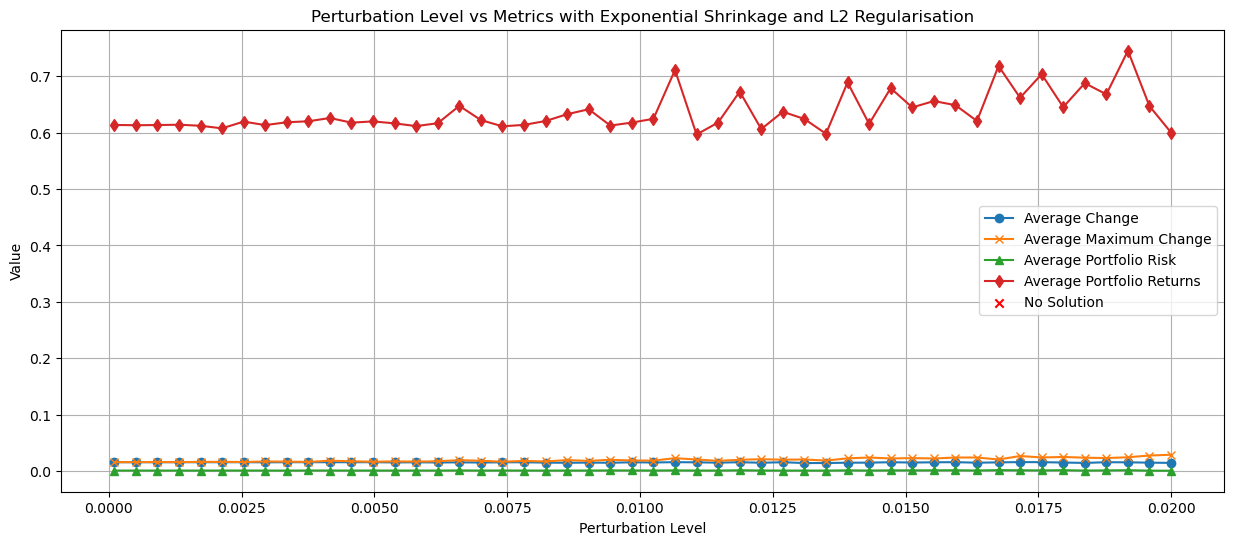

In [61]:
# Lists to store final results
tot_mean = []
tot_max = []
tot_std = []
optimal_returns = []
optimal_risks = []

# Regularization parameters
lambda_l2 = 0.2  # L2 regularisation strength (adjust as needed for diversification)

# Define exponential weighting factor
alpha = 0.94  # Exponential decay factor (adjust as needed for stabilization)

for perturbation in perturbations:
    weight_differences = []
    portfolio_returns = []
    portfolio_risks = []
    feasible_solution = True

    for i in range(5):
        # Add random perturbation to the returns data
        perturbed_returns = daily_returns + np.random.normal(0, perturbation, daily_returns.shape)
        
        # Fill missing values with column means to avoid dropping assets
        perturbed_returns = perturbed_returns.fillna(perturbed_returns.mean())

        # Calculate exponential shrinkage covariance matrix
        weighted_returns = perturbed_returns.copy()
        for t in range(1, len(perturbed_returns)):
            weighted_returns.iloc[t] *= alpha ** (len(perturbed_returns) - t)
        perturbed_cov_matrix = weighted_returns.cov() * 252  # Annualized covariance

        # Calculate expected returns (annualized)
        perturbed_expected_returns = perturbed_returns.mean() * 252

        # Define the optimization problem with cvxpy
        n_assets = len(perturbed_expected_returns)
        weights = cp.Variable(n_assets)

        # Portfolio return and risk (variance)
        portfolio_return = perturbed_expected_returns.values @ weights
        portfolio_risk = cp.quad_form(weights, cp.psd_wrap(perturbed_cov_matrix))

        # L2 penalty to encourage diversified weights
        l2_penalty = lambda_l2 * cp.norm(weights, 2)  # L2 regularisation

        # Optimization problem: Maximize return with L2 regularisation penalty
        target_risk = 0.08  # Set target risk level
        problem = cp.Problem(cp.Maximize(portfolio_return - l2_penalty), [
            cp.sum(weights) == 1,  # Sum of weights must be 1
            weights >= 0,  # No short-selling
            portfolio_risk <= target_risk**2  # Risk constraint
        ])
        
        problem.solve()

        # Check if solution is feasible
        if problem.status != cp.OPTIMAL:
            feasible_solution = False
            break

        # Collect results if feasible
        perturbed_weights = np.round(weights.value, 4)
        weight_diff = np.abs(original_weights - perturbed_weights)
        weight_differences.append(weight_diff)
        portfolio_returns.append(portfolio_return.value)
        portfolio_risks.append(portfolio_risk.value)

    # Append results if feasible
    if feasible_solution:
        diff_df = pd.DataFrame(weight_differences)
        tot_mean.append(diff_df.mean().mean())
        tot_max.append(diff_df.max().mean())
        tot_std.append(diff_df.std().mean())
        optimal_returns.append(np.mean(portfolio_returns))
        optimal_risks.append(np.mean(portfolio_risks))
    else:
        tot_mean.append(None)
        tot_max.append(None)
        tot_std.append(None)
        optimal_returns.append(None)
        optimal_risks.append(None)

# Creating a new DataFrame for analysis
final_df = pd.DataFrame({
    'Perturbation Level': perturbations,
    'Average Change': tot_mean,
    'Average Maximum Change': tot_max,
    'Average SD': tot_std,
    'Average Returns': optimal_returns,
    'Average Risk': optimal_risks
})

# Plotting the results
plt.figure(figsize=(15, 6))
for column, label, marker in zip(
        ['Average Change', 'Average Maximum Change', 'Average Risk', 'Average Returns'],
        ['Average Change', 'Average Maximum Change', 'Average Portfolio Risk', 'Average Portfolio Returns'],
        ['o', 'x', '^', 'd']):
    
    plt.plot(final_df['Perturbation Level'], final_df[column], label=label, marker=marker, linestyle='-')

nan_indices = final_df['Perturbation Level'][final_df.isna().any(axis=1)]
plt.scatter(nan_indices, [0] * len(nan_indices), color='red', marker='x', label='No Solution', zorder=3)

plt.xlabel('Perturbation Level')
plt.ylabel('Value')
plt.title('Perturbation Level vs Metrics with Exponential Shrinkage and L2 Regularisation')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
final_df

,Perturbation Level,Average Change,Average Maximum Change,Average SD,Average Returns,Average Risk
0,0.00010000000000000000,0.01570086142917948707,0.01574252809584615262,0.00003042294455761250,0.61373530203692117091,0.00094301747053193437
1,0.00050612244897959191,0.01570086142917948707,0.01583836142917948581,0.00011772378217203569,0.61323583166939887867,0.00093399654646050324
2,0.00091224489795918378,0.01570086142917948707,0.01600419476251281961,0.00026500366873770734,0.61351968161223069398,0.00093572596758652554
3,0.00131836734693877564,0.01570086142917948707,0.01593669476251281802,0.00019078638432667162,0.61415710066489448415,0.00091756402300363410
4,0.00172448979591836751,0.01570086142917948707,0.01624836142917948298,0.00044848727220884814,0.61226612074259278984,0.00093529920983037617
5,0.00213061224489795916,0.01570086142917948707,0.01639919476251281913,0.00054455307873113319,0.60769860726006563745,0.00094291232653781097
6,0.00253673469387755103,0.01570086142917948707,0.01609502809584615127,0.00028950868342379266,0.61966578973735342295,0.00097849841738443404
7,0.00294285714285714289,0.01552852809584615024,0.01706169476251281555,0.00142570317365454794,0.61346588799101442468,0.00094956929606242245
8,0.00334897959183673476,0.01570086142917948707,0.01675419476251282028,0.00082003522959552054,0.61847639365271789291,0.00088643607822182463
9,0.00375510204081632663,0.01570086142917948707,0.01626586142917948313,0.00043919528685995742,0.62023911491402428098,0.00102491527589886576


In [63]:
perturbed_weights

array([ 0.3642,  0.    ,  0.    , -0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.    ,
        0.    ,  0.    , -0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.    , -0.    ,
        0.    ,  0.    , -0.    , -0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
       -0.    , -0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    , -0.    ,  0.    , -0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.1521,  0.    ,  0.    ,  0.    ,
       -0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.    , -0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.2531,  0.    ,  0.    ,
        0.    , -0.    ,  0.    , -0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    , -0.    , -0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    , -0. 

#### L2 Regularisation + Dynamic Regularisation Strength + Soft Risk Constraint

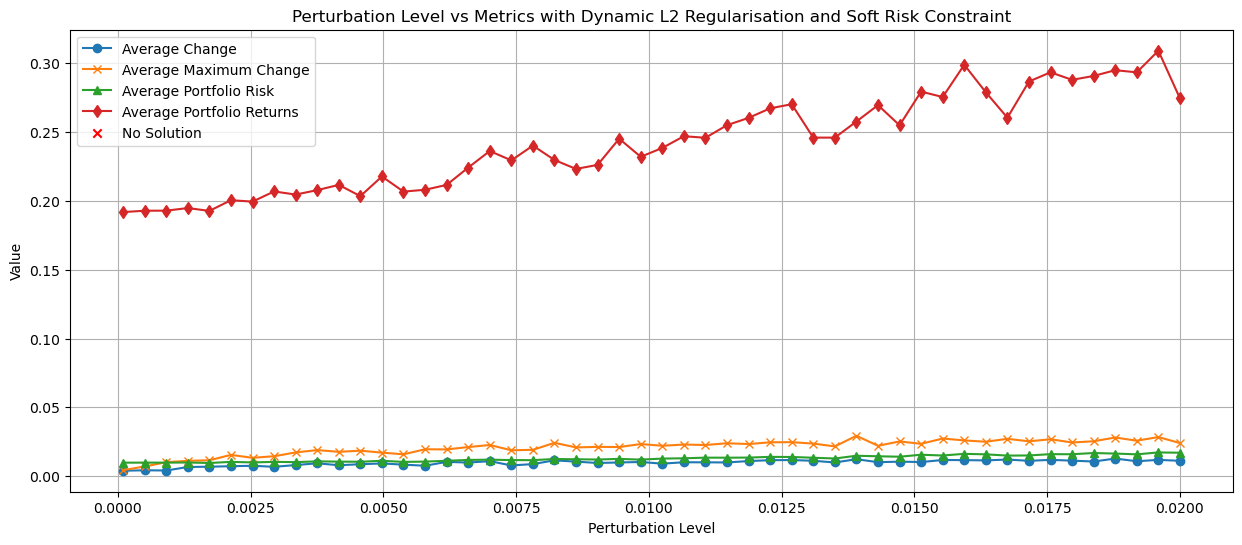

In [64]:
# Lists to store final results
tot_mean = []
tot_max = []
tot_std = []
optimal_returns = []
optimal_risks = []

for perturbation in perturbations:
    weight_differences = []
    portfolio_returns = []
    portfolio_risks = []
    feasible_solution = True

    # Adjust the regularization strength dynamically
    lambda_reg = 0.005 if perturbation > 0.01 else 0.01
    target_risk = 0.08  # Adjust target risk if needed

    for i in range(5):
        # Add random perturbation to the returns data
        perturbed_returns = daily_returns + np.random.normal(0, perturbation, daily_returns.shape)

        # Calculate sample covariance and expected returns
        perturbed_cov_matrix = perturbed_returns.cov() * 252
        perturbed_expected_returns = perturbed_returns.mean() * 252

        # Define optimization problem with L2 regularization and soft risk constraint
        n_assets = len(perturbed_expected_returns)
        weights = cp.Variable(n_assets)
        portfolio_return = perturbed_expected_returns.values @ weights
        portfolio_risk = cp.quad_form(weights, cp.psd_wrap(perturbed_cov_matrix))
        l2_penalty = lambda_reg * cp.norm(weights, 2)

        # Add soft risk constraint penalty
        risk_penalty_weight = 10
        problem = cp.Problem(cp.Maximize(portfolio_return - l2_penalty - risk_penalty_weight * cp.pos(portfolio_risk - target_risk**2)), [
            cp.sum(weights) == 1,
            weights >= 0,
        ])
        
        problem.solve()

        if problem.status != cp.OPTIMAL:
            feasible_solution = False
            break

        perturbed_weights = np.round(weights.value, 4)
        weight_diff = np.abs(original_weights - perturbed_weights)
        weight_differences.append(weight_diff)
        portfolio_returns.append(portfolio_return.value)
        portfolio_risks.append(portfolio_risk.value)

    # Collect results if feasible
    if feasible_solution:
        diff_df = pd.DataFrame(weight_differences)
        tot_mean.append(diff_df.mean().mean())
        tot_max.append(diff_df.max().mean())
        tot_std.append(diff_df.std().mean())
        optimal_returns.append(np.mean(portfolio_returns))
        optimal_risks.append(np.mean(portfolio_risks))
    else:
        tot_mean.append(None)
        tot_max.append(None)
        tot_std.append(None)
        optimal_returns.append(None)
        optimal_risks.append(None)

# Creating a new DataFrame for analysis
final_df = pd.DataFrame({
    'Perturbation Level': perturbations,
    'Average Change': tot_mean,
    'Average Maximum Change': tot_max,
    'Average SD': tot_std,
    'Average Returns': optimal_returns,
    'Average Risk': optimal_risks
})

# Plotting the results
plt.figure(figsize=(15, 6))
for column, label, marker in zip(
        ['Average Change', 'Average Maximum Change', 'Average Risk', 'Average Returns'],
        ['Average Change', 'Average Maximum Change', 'Average Portfolio Risk', 'Average Portfolio Returns'],
        ['o', 'x', '^', 'd']):
    
    plt.plot(final_df['Perturbation Level'], final_df[column], label=label, marker=marker, linestyle='-')

nan_indices = final_df['Perturbation Level'][final_df.isna().any(axis=1)]
plt.scatter(nan_indices, [0] * len(nan_indices), color='red', marker='x', label='No Solution', zorder=3)

plt.xlabel('Perturbation Level')
plt.ylabel('Value')
plt.title('Perturbation Level vs Metrics with Dynamic L2 Regularisation and Soft Risk Constraint')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
final_df

,Perturbation Level,Average Change,Average Maximum Change,Average SD,Average Returns,Average Risk
0,0.00010000000000000000,0.00393971243754725683,0.00435436931895734260,0.00036959721569532618,0.19186364631049981910,0.00978734643228301379
1,0.00050612244897959191,0.00426068545892760962,0.00701186928145819399,0.00199712925109764771,0.19286024048429561972,0.00982720319396059548
2,0.00091224489795918378,0.00409696127405654534,0.01014270259369156289,0.00394383576531704815,0.19290730223608157368,0.00980802910240218505
3,0.00131836734693877564,0.00663982793434236742,0.01112481030514786244,0.00375360323369426001,0.19478723895767252605,0.00991218184378573827
4,0.00172448979591836751,0.00687276205717368780,0.01152647696130255223,0.00351930587061707227,0.19272876900729563054,0.00956212598804681395
5,0.00213061224489795916,0.00721736392975165335,0.01544855589169958146,0.00585631929792108843,0.20049848318463911467,0.01036504820839916075
6,0.00253673469387755103,0.00753618396373569640,0.01331275606461223421,0.00519693922993452219,0.19947217726037561047,0.00996933716752684308
7,0.00294285714285714289,0.00678676824581738152,0.01446731183267589531,0.00543518892097333804,0.20686284351633585366,0.01036335509572275035
8,0.00334897959183673476,0.00805573287616715393,0.01723105703163529956,0.00668563345216817602,0.20460062082933472283,0.01018898869029927559
9,0.00375510204081632663,0.00932441741929563445,0.01893023579401358417,0.00749974839827258991,0.20781407330261814081,0.01073670751908621830


In [66]:
perturbed_weights

array([0.0057, 0.051 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0323, 0.    ,
       0.    , 0.0025, 0.    , 0.    , 0.    , 0.    , 0.    , 0.0898,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.0211, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0135, 0.0365,
       0.    , 0.    , 0.0621, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.0335, 0.    , 0.    , 0.    , 0.    , 0.    , 0.0196,
       0.0425, 0.0666, 0.0008, 0.    , 0.0692, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.0365, 0.    , 0.    , 0.    , 0.0073, 0.    ,
       0.    , 0.    , 0.0452, 0.0003, 0.    , 0.    , 0.1008, 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.0054, 0.    , 0.    ,
       0.    , 0.    , 0.0149, 0.0489, 0.0087, 0.0167, 0.    , 0.011 ,
       0.    , 0.0332, 0.    , 0.    , 0.    , 0.    , 0.    , 0.0542,
      

## Stability Across Time Periods

In [67]:
# Define time windows for different periods
time_windows = {
    "Pre-2008 Financial Crisis": ("2005-01-01", "2007-12-31"),
    "Global Financial Crisis": ("2008-01-01", "2009-12-31"),
    "Post-Crisis Recovery": ("2010-01-01", "2015-12-31"),
    "COVID-19 Pandemic": ("2020-01-01", "2021-12-31"),
    "Recent Period": ("2022-01-01", "2024-10-01")
}

In [68]:
# Calculate daily returns and removing first row
daily_returns = data.pct_change().iloc[1:,:]

# Lists to store optimal portfolio weights, returns, risks, and period labels
all_weights = []
optimal_returns = []
optimal_risks = []  # To store the portfolio risks
period_labels = []

# Run the optimization for each time window
for period, (start_date, end_date) in time_windows.items():
    sub_returns = daily_returns.loc[start_date:end_date]

    # Drop columns (assets) that have NaN values for this window
    sub_returns = sub_returns.dropna(axis=1, how='any')

    # If there are fewer than 2 assets left, skip this window
    if len(sub_returns.columns) < 2:
        continue

    sub_cov_matrix = sub_returns.cov() * 252  # Annualized covariance matrix
    sub_expected_returns = sub_returns.mean() * 252  # Annualized expected returns
    
    # Number of assets (after dropping assets with NaN values)
    n_assets = len(sub_expected_returns)

    # Define portfolio weights
    weights = cp.Variable(n_assets)

    # Define portfolio return and risk (variance)
    portfolio_return = sub_expected_returns.values @ weights
    # portfolio_risk = cp.quad_form(weights, cp.psd_wrap(sub_cov_matrix.values))
    portfolio_risk = weights.T @ cp.psd_wrap(sub_cov_matrix.values) @ weights

    # Optimize to maximize return for given risk
    target_risk = 0.08  # Set the target risk directly as the desired standard deviation

    problem = cp.Problem(cp.Maximize(portfolio_return), [
        cp.sum(weights) == 1,  # Sum of weights = 1
        weights >= 0,  # No short selling
        portfolio_risk <= target_risk**2  # Constrain risk to target risk (variance)
    ])
    
    result = problem.solve()
    
    print("Solver used:", problem.solver_stats.solver_name)

    # Ensure the problem was solved successfully
    if problem.status != cp.OPTIMAL:
        print(f"Optimization problem not solved: {problem.status}")
        continue
    
    # Ensure weights.value is a flat array
    optimal_weights = np.array(weights.value).flatten()

    # Store the optimal portfolio weights, returns, and risks for this time window
    all_weights.append(optimal_weights)  # Store the weights array
    optimal_returns.append(portfolio_return.value)  # Store return
    
    # Check if portfolio_risk.value is valid before calculating standard deviation
    if portfolio_risk.value is not None:
        optimal_risks.append(np.sqrt(portfolio_risk.value))  # Store the risk (standard deviation)
    else:
        print("Warning: Portfolio risk is None")
        optimal_risks.append(None)  # Handle None risk values as needed

    # Store the start and end dates of this period for labeling
    period_labels.append(period)

# Convert the list of weights to a DataFrame for better plotting
weights_df = pd.DataFrame(all_weights, columns=tickers, index=period_labels)

# Now you also have the risks and returns for each period
risks_df = pd.DataFrame({
    'Period': period_labels,
    'Return': optimal_returns,
    'Risk': optimal_risks
})

period_labels = weights_df.index.tolist()

# Get a qualitative color scale from Plotly
color_scale = px.colors.qualitative.Plotly

# Dynamically assign colors to tickers (expand the color scale to cover all tickers if necessary)
tickers = weights_df.columns

# Generate a unique color for each ticker using a continuous color scale
color_scale = px.colors.sequential.Inferno  # You can choose another color scale if preferred
color_map = {ticker: px.colors.sample_colorscale(color_scale, i / len(tickers)) for i, ticker in enumerate(tickers)}

# Sort the weights_df for each time period so that larger values are at the bottom
sorted_assets = sorted(weights_df.columns)

# Plot 1: Stacked Bar Plot of Optimal Weights Over Time
fig_weights = go.Figure()

# Add a bar for each asset in the sorted dataframe, adding smaller weights last
for period in period_labels:
    # Sort the assets by weight for this period in descending order
    sorted_weights = weights_df.loc[period].sort_values(ascending=False)
    for asset in sorted_weights.index:
        fig_weights.add_trace(go.Bar(
            x=[period], 
            y=[sorted_weights[asset]], 
            name=asset if period == period_labels[0] else '',  # Show asset name in legend only once
            hovertemplate=asset + '<br>%{y:.2f}',  # Asset name first, then y-axis value
            hoverinfo='y',  # Show only the y value
            showlegend=(period == period_labels[0]),  # Show legend only once
            marker=dict(color=color_map[asset])  # Use dynamically generated unique colors
        ))

# Set plot layout for the stacked bar chart
fig_weights.update_layout(
    barmode='stack',
    title='Optimal Portfolio Weights Over Time',
    xaxis=dict(title='Time Periods', tickangle=45),
    yaxis=dict(title='Weight'),
    legend=dict(title="Assets", yanchor="top", xanchor="left"),
    height=600,
    width=1000
)

# Display the sorted stacked bar chart
fig_weights.show()

# Plot portfolio returns and risks over time (unchanged)
fig_risk_return = go.Figure()

# Add line plot for returns
fig_risk_return.add_trace(go.Scatter(
    x=risks_df['Period'],
    y=risks_df['Return'],
    mode='lines+markers',
    name='Return',
    line=dict(color='blue'),
    hovertemplate='Return: %{y:.2f}<extra></extra>'
))

# Add line plot for risks
fig_risk_return.add_trace(go.Scatter(
    x=risks_df['Period'],
    y=risks_df['Risk'],
    mode='lines+markers',
    name='Risk',
    line=dict(color='red'),
    hovertemplate='Risk: %{y:.2f}<extra></extra>'
))

# Update the layout for the risk-return plot
fig_risk_return.update_layout(
    title='Optimal Portfolio Returns and Risks Over Time',
    xaxis=dict(title='Time Periods', tickangle=45),
    yaxis=dict(title='Value'),
    legend=dict(title="Metrics", yanchor="top", xanchor="left"),
    height=600,
    width=1000
)

# Show the risk-return plot
fig_risk_return.show()

/var/folders/0q/3_k17wq97378_rpc0k5cjj_m0000gn/T/ipykernel_3771/2915363280.py:2: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.



Solver used: ECOS
Solver used: ECOS
Solver used: ECOS
Solver used: ECOS
Solver used: ECOS
